<h2> Exercise 1
  

In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import imageio
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200


# these lines are necessary for some reason, because otherwise the kernel keeps on dying when using matplotlib (on my machine at least)
import os    
import sys
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
current_dir = os.getcwd()
# output path were generated images will be stored
output_path = os.path.join(current_dir,"outputs")
print(output_path)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

C:\Users\User\Desktop\Uni\Semester2\DeepLearning\outputs
cuda


In [3]:
# preparing data
data = torch.utils.data.DataLoader(
        torchvision.datasets.FashionMNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

In [4]:
# the VAE will be constructed by an Encoder class, a decoder class and a VAE class combining the two
# The Encoder Class: 

class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.norm = torch.distributions.Normal(0, 1)
        # mean and standard deviation 
        self.norm.loc = self.norm.loc.cuda()
        self.norm.scale = self.norm.scale.cuda()
        # kl divergence
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        # exp ensures sigma > 0
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.norm.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [5]:
# The Decoder class
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        x = F.relu(self.linear1(z))
        x = torch.sigmoid(self.linear2(x))
        return x.reshape((-1, 1, 28, 28))

In [6]:
# Combining the two to a VAE class
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [7]:
# train function
def train(autoencoder, data, epochs=30):
    total_loss = []
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            total_loss.append(loss.to("cpu").detach().numpy())
            loss.backward()
            opt.step()
    return autoencoder, total_loss

In [8]:
vae = VariationalAutoencoder(2).to(device)
vae, total_loss = train(vae,data)

Text(0, 0.5, 'error')

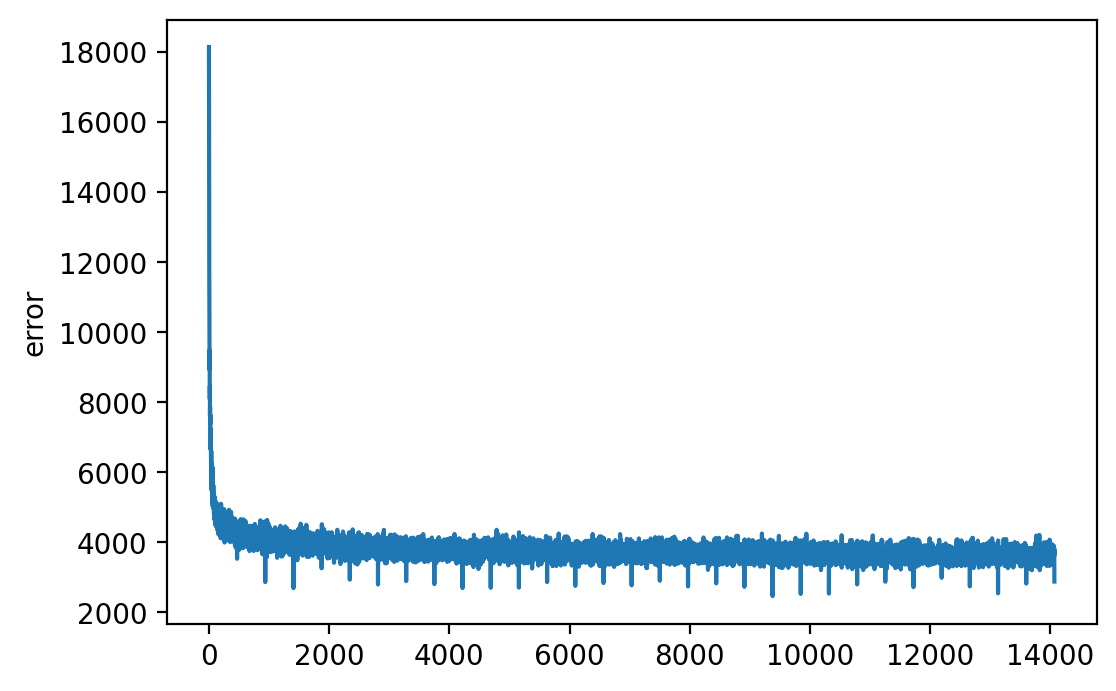

In [9]:
plt.plot(total_loss)
plt.ylabel("error")

In [14]:
# sampling vectors from the latent space and displaying the according reconstruction
# r0 = (x_lower, x_upper), r1 = (y_lower, y_upper), n = number of images to reconstruct
def plot_reconstruction(VAE, r0, r1, n):
    
    # images are of dimension 28*28
    img_dim = 28
    img = np.zeros((n*img_dim, n*img_dim))
    # fill the "grid" with the decoded vector of the latent space at the current position
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_recon = VAE.decoder(z).reshape(img_dim, img_dim).to('cpu').detach().numpy()
            img[(n-1-i)*img_dim:(n-1-i+1)*img_dim, j*img_dim:(j+1)*img_dim] = x_recon
    plt.imshow(img, extent=[*r0, *r1])

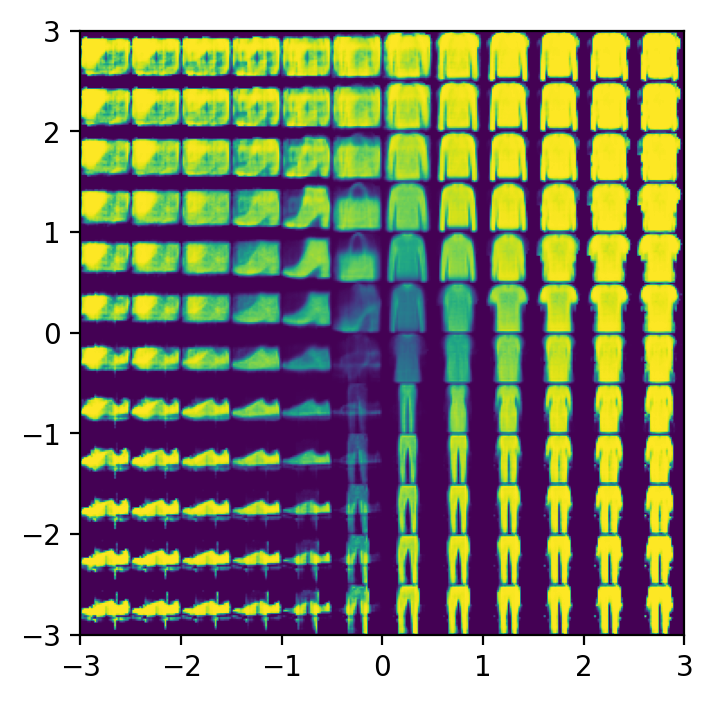

In [16]:
plot_reconstruction(vae, r0=(-3, 3), r1=(-3, 3), n=12)

In [17]:
def interpolate(autoencoder, x_1, x_2, n=15):
    # encode both points
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    # create a stack of tensors "along a line" between z_1 and z_2 and decode that stack
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    # display the list of images in a line
    img_dims = 28
    img = np.zeros((img_dims, n*img_dims))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*img_dims:(i+1)*img_dims] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [18]:
x, y = next(iter(data))
x_1 = x[y == 2][1].to(device)
x_2 = x[y == 8][1].to(device)

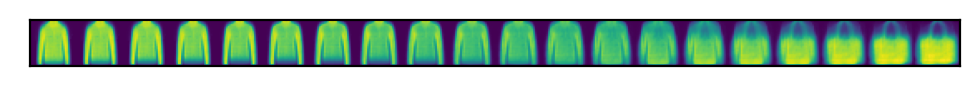

In [19]:
interpolate(vae, x_1, x_2, n=20)

<h3> Exercise 2.2

In [20]:
# params
batch_size = 512
epochs = 200
sample_size = 64 # fixed sample size
latent_dims = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
learning_rate = 0.0002
loss_function = nn.BCELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
# transformation to tensor and normalized
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),])
# transformation in order to later create a GIF of the reconstruction
to_pil_image = transforms.ToPILImage()

In [22]:
# prepare dataLoader
train_data = torchvision.datasets.FashionMNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [23]:
# the GAN consists of a Generator class and a Discriminator class. Both consist of alternating linear and Relu layers. 
class Generator(nn.Module):
    def __init__(self, latent_dims):
        super(Generator, self).__init__()
        self.latent_dims = latent_dims
        self.main = nn.Sequential(
            nn.Linear(self.latent_dims, 256),
            nn.ReLU(0.3),
            nn.Linear(256, 512),
            nn.ReLU(0.3),
            nn.Linear(512, 1024),
            nn.ReLU(0.3),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

In [24]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.ReLU(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(0.3),
            nn.Linear(512, 256),
            nn.ReLU(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [25]:
generator = Generator(latent_dims).to(device)
discriminator = Discriminator().to(device)

In [26]:
# optimizers
optim_gen = optim.Adam(generator.parameters(), lr=learning_rate)
optim_dis = optim.Adam(discriminator.parameters(), lr=learning_rate)

In [27]:
generator_losses = [] 
discriminator_losses = [] 
images = [] 

In [28]:
# helper functions to create vector of real (1) or fake (0) labels of given size 
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)


def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [29]:
# helper function to create ranodm noise
def create_noise(sample_size, latent_dims):
    return torch.randn(sample_size, latent_dims).to(device)

In [30]:
# save a generator- generated image
def save_generator_image(image, path):
    save_image(image, path)

In [31]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = loss_function(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = loss_function(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [32]:
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)

    optimizer.zero_grad()

    output = discriminator(data_fake)
    loss = loss_function(output, real_label)

    loss.backward()
    optimizer.step()

    return loss

In [33]:
noise = create_noise(sample_size, latent_dims)

In [34]:
generator.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=256, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [ ]:
for epoch in range(epochs):
    loss_gen = 0.0
    loss_dis = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
       
        for step in range(k):
            data_fake = generator(create_noise(b_size, latent_dims)).detach()
            data_real = image
            # train discriminator 
            loss_dis += train_discriminator(optim_dis, data_real, data_fake)
        data_fake = generator(create_noise(b_size, latent_dims))
        # train  generator 
        loss_gen += train_generator(optim_gen, data_fake)
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    # make the images as grid
    generated_img = make_grid(generated_img)
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, output_path+"/" + str(epoch)+ ".png")
    images.append(generated_img)
    epoch_loss_g = loss_gen / bi
    epoch_loss_d = loss_dis / bi
    generator_losses.append(epoch_loss_g)
    discriminator_losses.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

118it [00:11, 10.40it/s]                                                                                               


Epoch 0 of 200
Generator loss: 1.35722518, Discriminator loss: 0.56506163


118it [00:11,  9.98it/s]                                                                                               


Epoch 1 of 200
Generator loss: 7.16819286, Discriminator loss: 0.06174941


118it [00:12,  9.49it/s]                                                                                               


Epoch 2 of 200
Generator loss: 12.34698105, Discriminator loss: 0.00760769


118it [00:12,  9.79it/s]                                                                                               


Epoch 3 of 200
Generator loss: 13.02061462, Discriminator loss: 0.02823326


118it [00:12,  9.73it/s]                                                                                               


Epoch 4 of 200
Generator loss: 7.64517307, Discriminator loss: 0.03280240


118it [00:12,  9.73it/s]                                                                                               


Epoch 5 of 200
Generator loss: 11.02892208, Discriminator loss: 0.21676102


118it [00:12,  9.76it/s]                                                                                               


Epoch 6 of 200
Generator loss: 8.56971741, Discriminator loss: 0.08293040


118it [00:12,  9.69it/s]                                                                                               


Epoch 7 of 200
Generator loss: 8.51475430, Discriminator loss: 0.05107693


118it [00:12,  9.66it/s]                                                                                               


Epoch 8 of 200
Generator loss: 10.50653934, Discriminator loss: 0.06305391


118it [00:12,  9.67it/s]                                                                                               


Epoch 9 of 200
Generator loss: 10.26855755, Discriminator loss: 0.13581239


118it [00:12,  9.83it/s]                                                                                               


Epoch 10 of 200
Generator loss: 9.59367943, Discriminator loss: 0.10171112


118it [00:12,  9.39it/s]                                                                                               


Epoch 11 of 200
Generator loss: 7.97823238, Discriminator loss: 0.14079566


118it [00:12,  9.12it/s]                                                                                               


Epoch 12 of 200
Generator loss: 10.10116482, Discriminator loss: 0.18564929


118it [00:12,  9.48it/s]                                                                                               


Epoch 13 of 200
Generator loss: 7.03995895, Discriminator loss: 0.11783881


118it [00:12,  9.36it/s]                                                                                               


Epoch 14 of 200
Generator loss: 7.66429377, Discriminator loss: 0.22097670


118it [00:12,  9.30it/s]                                                                                               


Epoch 15 of 200
Generator loss: 5.07342386, Discriminator loss: 0.13201751


118it [00:12,  9.37it/s]                                                                                               


Epoch 16 of 200
Generator loss: 6.08547783, Discriminator loss: 0.10998085


118it [00:12,  9.58it/s]                                                                                               


Epoch 17 of 200
Generator loss: 6.51503754, Discriminator loss: 0.19060026


118it [00:12,  9.55it/s]                                                                                               


Epoch 18 of 200
Generator loss: 6.74204493, Discriminator loss: 0.12761572


118it [00:12,  9.58it/s]                                                                                               


Epoch 19 of 200
Generator loss: 6.01823092, Discriminator loss: 0.24319544


118it [00:12,  9.82it/s]                                                                                               


Epoch 20 of 200
Generator loss: 6.43620968, Discriminator loss: 0.16493654


118it [00:12,  9.77it/s]                                                                                               


Epoch 21 of 200
Generator loss: 5.77965307, Discriminator loss: 0.20379734


118it [00:13,  8.92it/s]                                                                                               


Epoch 22 of 200
Generator loss: 5.65230370, Discriminator loss: 0.24734850


118it [00:12,  9.53it/s]                                                                                               


Epoch 23 of 200
Generator loss: 5.84529114, Discriminator loss: 0.15378752


118it [00:12,  9.51it/s]                                                                                               


Epoch 24 of 200
Generator loss: 5.60590506, Discriminator loss: 0.16136375


118it [00:12,  9.25it/s]                                                                                               


Epoch 25 of 200
Generator loss: 6.10354948, Discriminator loss: 0.21224684


118it [00:12,  9.22it/s]                                                                                               


Epoch 26 of 200
Generator loss: 6.48469019, Discriminator loss: 0.24250612


118it [00:12,  9.25it/s]                                                                                               


Epoch 27 of 200
Generator loss: 5.68031788, Discriminator loss: 0.18400060


118it [00:12,  9.21it/s]                                                                                               


Epoch 28 of 200
Generator loss: 7.33831453, Discriminator loss: 0.22194237


118it [00:13,  9.05it/s]                                                                                               


Epoch 29 of 200
Generator loss: 5.32433653, Discriminator loss: 0.25057191


118it [00:12,  9.26it/s]                                                                                               


Epoch 30 of 200
Generator loss: 4.68872595, Discriminator loss: 0.22870889


118it [00:13,  8.95it/s]                                                                                               


Epoch 31 of 200
Generator loss: 4.96580601, Discriminator loss: 0.19301702


118it [00:12,  9.16it/s]                                                                                               


Epoch 32 of 200
Generator loss: 4.97200108, Discriminator loss: 0.23458776


118it [00:12,  9.27it/s]                                                                                               


Epoch 33 of 200
Generator loss: 5.37724876, Discriminator loss: 0.20341690


118it [00:12,  9.44it/s]                                                                                               


Epoch 34 of 200
Generator loss: 4.04456854, Discriminator loss: 0.33283353


118it [00:12,  9.52it/s]                                                                                               


Epoch 35 of 200
Generator loss: 5.63299131, Discriminator loss: 0.20915192


118it [00:12,  9.41it/s]                                                                                               


Epoch 36 of 200
Generator loss: 7.08849382, Discriminator loss: 0.45369944


118it [00:12,  9.43it/s]                                                                                               


Epoch 37 of 200
Generator loss: 5.62268925, Discriminator loss: 0.22546074


118it [00:12,  9.33it/s]                                                                                               


Epoch 38 of 200
Generator loss: 4.96627235, Discriminator loss: 0.16150753


118it [00:12,  9.34it/s]                                                                                               


Epoch 39 of 200
Generator loss: 4.44413567, Discriminator loss: 0.21971652


118it [00:12,  9.30it/s]                                                                                               


Epoch 40 of 200
Generator loss: 4.95897102, Discriminator loss: 0.35424468


118it [00:12,  9.23it/s]                                                                                               


Epoch 41 of 200
Generator loss: 5.34222603, Discriminator loss: 0.27845159


118it [00:12,  9.19it/s]                                                                                               


Epoch 42 of 200
Generator loss: 5.29101515, Discriminator loss: 0.28273231


118it [00:12,  9.26it/s]                                                                                               


Epoch 43 of 200
Generator loss: 4.69307232, Discriminator loss: 0.50060982


118it [00:12,  9.20it/s]                                                                                               


Epoch 44 of 200
Generator loss: 7.79653978, Discriminator loss: 0.44655806


118it [00:12,  9.22it/s]                                                                                               


Epoch 45 of 200
Generator loss: 4.68989372, Discriminator loss: 0.29238188


118it [00:12,  9.14it/s]                                                                                               


Epoch 46 of 200
Generator loss: 6.31107473, Discriminator loss: 0.28284740


118it [00:12,  9.24it/s]                                                                                               


Epoch 47 of 200
Generator loss: 6.70625305, Discriminator loss: 0.49210387


118it [00:12,  9.27it/s]                                                                                               


Epoch 48 of 200
Generator loss: 5.92479372, Discriminator loss: 0.51797557


118it [00:12,  9.19it/s]                                                                                               


Epoch 49 of 200
Generator loss: 4.85952759, Discriminator loss: 0.21933357


118it [00:12,  9.10it/s]                                                                                               


Epoch 50 of 200
Generator loss: 3.85720348, Discriminator loss: 0.26402923


118it [00:12,  9.16it/s]                                                                                               


Epoch 51 of 200
Generator loss: 4.32916498, Discriminator loss: 0.34446737


118it [00:12,  9.12it/s]                                                                                               


Epoch 52 of 200
Generator loss: 5.24668646, Discriminator loss: 0.35839266


118it [00:12,  9.14it/s]                                                                                               


Epoch 53 of 200
Generator loss: 7.44288969, Discriminator loss: 0.68422914


118it [00:12,  9.08it/s]                                                                                               


Epoch 54 of 200
Generator loss: 6.70161057, Discriminator loss: 0.49510720


118it [00:13,  9.08it/s]                                                                                               


Epoch 55 of 200
Generator loss: 5.05784130, Discriminator loss: 0.29280353


118it [00:12,  9.09it/s]                                                                                               


Epoch 56 of 200
Generator loss: 4.25740671, Discriminator loss: 0.30022323


118it [00:12,  9.14it/s]                                                                                               


Epoch 57 of 200
Generator loss: 4.48494101, Discriminator loss: 0.34556133


118it [00:13,  9.00it/s]                                                                                               


Epoch 58 of 200
Generator loss: 4.85921192, Discriminator loss: 0.33522457


118it [00:13,  9.05it/s]                                                                                               


Epoch 59 of 200
Generator loss: 3.72156143, Discriminator loss: 0.36023450


118it [00:13,  9.05it/s]                                                                                               


Epoch 60 of 200
Generator loss: 4.64682293, Discriminator loss: 0.39253074


118it [00:12,  9.09it/s]                                                                                               


Epoch 61 of 200
Generator loss: 4.36721087, Discriminator loss: 0.34833533


118it [00:13,  8.97it/s]                                                                                               


Epoch 62 of 200
Generator loss: 4.97788906, Discriminator loss: 0.35419172


118it [00:12,  9.09it/s]                                                                                               


Epoch 63 of 200
Generator loss: 7.64205503, Discriminator loss: 0.46026260


118it [00:13,  9.01it/s]                                                                                               


Epoch 64 of 200
Generator loss: 5.69785738, Discriminator loss: 0.56552857


118it [00:12,  9.09it/s]                                                                                               


Epoch 65 of 200
Generator loss: 4.40269327, Discriminator loss: 0.40503767


118it [00:13,  8.99it/s]                                                                                               


Epoch 66 of 200
Generator loss: 4.20740414, Discriminator loss: 0.30816653


118it [00:13,  9.04it/s]                                                                                               


Epoch 67 of 200
Generator loss: 5.52361250, Discriminator loss: 0.51920241


118it [00:13,  8.95it/s]                                                                                               


Epoch 68 of 200
Generator loss: 4.94147825, Discriminator loss: 0.48214781


118it [00:13,  8.98it/s]                                                                                               


Epoch 69 of 200
Generator loss: 4.65395975, Discriminator loss: 0.54427540


118it [00:13,  9.01it/s]                                                                                               


Epoch 70 of 200
Generator loss: 4.56477261, Discriminator loss: 0.57047236


118it [00:13,  9.05it/s]                                                                                               


Epoch 71 of 200
Generator loss: 3.51188946, Discriminator loss: 0.39213499


118it [00:13,  9.05it/s]                                                                                               


Epoch 72 of 200
Generator loss: 3.29275393, Discriminator loss: 0.36346748


118it [00:13,  9.05it/s]                                                                                               


Epoch 73 of 200
Generator loss: 3.68710113, Discriminator loss: 0.39109620


118it [00:13,  8.98it/s]                                                                                               


Epoch 74 of 200
Generator loss: 4.58376789, Discriminator loss: 0.41611508


118it [00:13,  8.99it/s]                                                                                               


Epoch 75 of 200
Generator loss: 3.80356383, Discriminator loss: 0.48948655


118it [00:13,  8.99it/s]                                                                                               


Epoch 76 of 200
Generator loss: 4.30114126, Discriminator loss: 0.41151375


118it [00:13,  9.04it/s]                                                                                               


Epoch 77 of 200
Generator loss: 4.92239857, Discriminator loss: 0.53473175


118it [00:13,  9.04it/s]                                                                                               


Epoch 78 of 200
Generator loss: 3.23520589, Discriminator loss: 0.40439788


118it [00:13,  8.99it/s]                                                                                               


Epoch 79 of 200
Generator loss: 3.81876969, Discriminator loss: 0.37917110


118it [00:13,  8.93it/s]                                                                                               


Epoch 80 of 200
Generator loss: 4.58893442, Discriminator loss: 0.40098721


118it [00:13,  8.97it/s]                                                                                               


Epoch 81 of 200
Generator loss: 5.05885553, Discriminator loss: 0.46766600


118it [00:13,  8.99it/s]                                                                                               


Epoch 82 of 200
Generator loss: 5.51898956, Discriminator loss: 0.32918006


118it [00:13,  8.99it/s]                                                                                               


Epoch 83 of 200
Generator loss: 4.66051340, Discriminator loss: 0.39619568


118it [00:12,  9.15it/s]                                                                                               


Epoch 84 of 200
Generator loss: 3.69346213, Discriminator loss: 0.33677575


118it [00:13,  9.00it/s]                                                                                               


Epoch 85 of 200
Generator loss: 4.27219057, Discriminator loss: 0.44479471


118it [00:13,  9.00it/s]                                                                                               


Epoch 86 of 200
Generator loss: 5.54888153, Discriminator loss: 0.64607358


118it [00:13,  8.95it/s]                                                                                               


Epoch 87 of 200
Generator loss: 4.77523851, Discriminator loss: 0.54807729


118it [00:13,  8.86it/s]                                                                                               


Epoch 88 of 200
Generator loss: 3.33591342, Discriminator loss: 0.32095689


118it [00:13,  9.05it/s]                                                                                               


Epoch 89 of 200
Generator loss: 3.25777578, Discriminator loss: 0.39599350


118it [00:13,  8.94it/s]                                                                                               


Epoch 90 of 200
Generator loss: 4.20656157, Discriminator loss: 0.50333124


118it [00:13,  8.96it/s]                                                                                               


Epoch 91 of 200
Generator loss: 4.25883198, Discriminator loss: 0.51864350


118it [00:13,  8.87it/s]                                                                                               


Epoch 92 of 200
Generator loss: 3.72384453, Discriminator loss: 0.49876159


118it [00:13,  8.93it/s]                                                                                               


Epoch 93 of 200
Generator loss: 3.53095460, Discriminator loss: 0.45095587


118it [00:13,  8.91it/s]                                                                                               


Epoch 94 of 200
Generator loss: 4.04062653, Discriminator loss: 0.34866619


118it [00:13,  8.94it/s]                                                                                               


Epoch 95 of 200
Generator loss: 5.20975208, Discriminator loss: 0.54191047


118it [00:13,  8.91it/s]                                                                                               


Epoch 96 of 200
Generator loss: 4.80445194, Discriminator loss: 0.67310649


118it [00:13,  8.96it/s]                                                                                               


Epoch 97 of 200
Generator loss: 3.91881537, Discriminator loss: 0.62079632


118it [00:13,  8.89it/s]                                                                                               


Epoch 98 of 200
Generator loss: 3.68461370, Discriminator loss: 0.45835462


118it [00:13,  8.96it/s]                                                                                               


Epoch 99 of 200
Generator loss: 3.11920905, Discriminator loss: 0.51672888


118it [00:13,  8.90it/s]                                                                                               


Epoch 100 of 200
Generator loss: 4.31682396, Discriminator loss: 0.59151149


118it [00:13,  8.87it/s]                                                                                               


Epoch 101 of 200
Generator loss: 5.60263443, Discriminator loss: 0.68116653


118it [00:13,  9.04it/s]                                                                                               


Epoch 102 of 200
Generator loss: 3.93723106, Discriminator loss: 0.49854496


118it [00:13,  8.94it/s]                                                                                               


Epoch 103 of 200
Generator loss: 3.89977837, Discriminator loss: 0.48290619


118it [00:13,  8.90it/s]                                                                                               


Epoch 104 of 200
Generator loss: 3.20324492, Discriminator loss: 0.63750339


118it [00:13,  8.87it/s]                                                                                               


Epoch 105 of 200
Generator loss: 3.35608625, Discriminator loss: 0.58050561


118it [00:13,  8.86it/s]                                                                                               


Epoch 106 of 200
Generator loss: 3.74327946, Discriminator loss: 0.58117491


118it [00:13,  8.90it/s]                                                                                               


Epoch 107 of 200
Generator loss: 3.39712572, Discriminator loss: 0.61244869


118it [00:13,  8.78it/s]                                                                                               


Epoch 108 of 200
Generator loss: 2.82905459, Discriminator loss: 0.51803070


118it [00:13,  8.81it/s]                                                                                               


Epoch 109 of 200
Generator loss: 3.62958980, Discriminator loss: 0.46779242


118it [00:13,  8.96it/s]                                                                                               


Epoch 110 of 200
Generator loss: 3.57274246, Discriminator loss: 0.48090848


118it [00:13,  8.81it/s]                                                                                               


Epoch 111 of 200
Generator loss: 3.84676290, Discriminator loss: 0.44720712


118it [00:13,  8.80it/s]                                                                                               


Epoch 112 of 200
Generator loss: 3.39731526, Discriminator loss: 0.54236484


118it [00:13,  8.77it/s]                                                                                               


Epoch 113 of 200
Generator loss: 3.02967143, Discriminator loss: 0.51674068


118it [00:13,  8.70it/s]                                                                                               


Epoch 114 of 200
Generator loss: 3.01533151, Discriminator loss: 0.44954532


118it [00:13,  8.71it/s]                                                                                               


Epoch 115 of 200
Generator loss: 3.92227745, Discriminator loss: 0.48983636


118it [00:13,  8.69it/s]                                                                                               


Epoch 116 of 200
Generator loss: 3.10014796, Discriminator loss: 0.47325164


118it [00:13,  8.75it/s]                                                                                               


Epoch 117 of 200
Generator loss: 3.23288965, Discriminator loss: 0.49672988


118it [00:13,  8.72it/s]                                                                                               


Epoch 118 of 200
Generator loss: 3.86043072, Discriminator loss: 0.45870247


118it [00:13,  8.81it/s]                                                                                               


Epoch 119 of 200
Generator loss: 3.43096352, Discriminator loss: 0.53045040


118it [00:13,  8.72it/s]                                                                                               


Epoch 120 of 200
Generator loss: 3.49917650, Discriminator loss: 0.47663775


118it [00:13,  8.56it/s]                                                                                               


Epoch 121 of 200
Generator loss: 3.13248348, Discriminator loss: 0.49658027


118it [00:13,  8.79it/s]                                                                                               


Epoch 122 of 200
Generator loss: 3.66983294, Discriminator loss: 0.48520496


118it [00:13,  8.64it/s]                                                                                               


Epoch 123 of 200
Generator loss: 3.02938414, Discriminator loss: 0.45028108


118it [00:13,  8.70it/s]                                                                                               


Epoch 124 of 200
Generator loss: 3.54591393, Discriminator loss: 0.49861792


118it [00:13,  8.74it/s]                                                                                               


Epoch 125 of 200
Generator loss: 3.34230518, Discriminator loss: 0.46256378


118it [00:13,  8.69it/s]                                                                                               


Epoch 126 of 200
Generator loss: 4.41746855, Discriminator loss: 0.38699558


118it [00:13,  8.47it/s]                                                                                               


Epoch 127 of 200
Generator loss: 4.29009199, Discriminator loss: 0.52723914


118it [00:13,  8.73it/s]                                                                                               


Epoch 128 of 200
Generator loss: 3.72162676, Discriminator loss: 0.44443920


118it [00:13,  8.73it/s]                                                                                               


Epoch 129 of 200
Generator loss: 4.36232615, Discriminator loss: 0.38361830


118it [00:13,  8.58it/s]                                                                                               


Epoch 130 of 200
Generator loss: 4.42515659, Discriminator loss: 0.50895470


118it [00:13,  8.72it/s]                                                                                               


Epoch 131 of 200
Generator loss: 3.35953712, Discriminator loss: 0.47224379


118it [00:13,  8.66it/s]                                                                                               


Epoch 132 of 200
Generator loss: 3.50228357, Discriminator loss: 0.50822467


118it [00:13,  8.68it/s]                                                                                               


Epoch 133 of 200
Generator loss: 3.46853137, Discriminator loss: 0.54608917


118it [00:13,  8.50it/s]                                                                                               


Epoch 134 of 200
Generator loss: 3.84388018, Discriminator loss: 0.52794600


118it [00:13,  8.61it/s]                                                                                               


Epoch 135 of 200
Generator loss: 3.70227957, Discriminator loss: 0.51187521


118it [00:13,  8.55it/s]                                                                                               


Epoch 136 of 200
Generator loss: 3.52495432, Discriminator loss: 0.53926480


118it [00:13,  8.53it/s]                                                                                               


Epoch 137 of 200
Generator loss: 3.16333270, Discriminator loss: 0.55513328


118it [00:13,  8.68it/s]                                                                                               


Epoch 138 of 200
Generator loss: 3.31170607, Discriminator loss: 0.49280420


118it [00:13,  8.57it/s]                                                                                               


Epoch 139 of 200
Generator loss: 3.22027040, Discriminator loss: 0.47022671


118it [00:13,  8.55it/s]                                                                                               


Epoch 140 of 200
Generator loss: 3.10179877, Discriminator loss: 0.56823152


118it [00:13,  8.63it/s]                                                                                               


Epoch 141 of 200
Generator loss: 3.47772384, Discriminator loss: 0.46169159


118it [00:13,  8.66it/s]                                                                                               


Epoch 142 of 200
Generator loss: 2.95712733, Discriminator loss: 0.47765720


118it [00:13,  8.61it/s]                                                                                               


Epoch 143 of 200
Generator loss: 3.96794319, Discriminator loss: 0.46725658


118it [00:13,  8.55it/s]                                                                                               


Epoch 144 of 200
Generator loss: 3.61220121, Discriminator loss: 0.40557390


118it [00:14,  8.41it/s]                                                                                               


Epoch 145 of 200
Generator loss: 4.42871761, Discriminator loss: 0.67071289


118it [00:13,  8.54it/s]                                                                                               


Epoch 146 of 200
Generator loss: 3.89030600, Discriminator loss: 0.57866371


118it [00:13,  8.46it/s]                                                                                               


Epoch 147 of 200
Generator loss: 3.10220575, Discriminator loss: 0.63140655


118it [00:13,  8.50it/s]                                                                                               


Epoch 148 of 200
Generator loss: 2.74116302, Discriminator loss: 0.51096559


118it [00:14,  8.38it/s]                                                                                               


Epoch 149 of 200
Generator loss: 3.32919216, Discriminator loss: 0.53705692


118it [00:13,  8.51it/s]                                                                                               


Epoch 150 of 200
Generator loss: 3.38407063, Discriminator loss: 0.55233270


118it [00:13,  8.53it/s]                                                                                               


Epoch 151 of 200
Generator loss: 3.72912860, Discriminator loss: 0.59686750


118it [00:13,  8.49it/s]                                                                                               


Epoch 152 of 200
Generator loss: 2.90454197, Discriminator loss: 0.50872356


118it [00:13,  8.48it/s]                                                                                               


Epoch 153 of 200
Generator loss: 3.19194651, Discriminator loss: 0.51466304


118it [00:14,  8.35it/s]                                                                                               


Epoch 154 of 200
Generator loss: 3.30471635, Discriminator loss: 0.45805895


118it [00:13,  8.45it/s]                                                                                               


Epoch 155 of 200
Generator loss: 3.44465065, Discriminator loss: 0.54286289


118it [00:13,  8.52it/s]                                                                                               


Epoch 156 of 200
Generator loss: 3.87709975, Discriminator loss: 0.52627879


118it [00:13,  8.47it/s]                                                                                               


Epoch 157 of 200
Generator loss: 3.39515471, Discriminator loss: 0.53694946


118it [00:13,  8.50it/s]                                                                                               


Epoch 158 of 200
Generator loss: 2.84701300, Discriminator loss: 0.57120442


118it [00:13,  8.44it/s]                                                                                               


Epoch 159 of 200
Generator loss: 3.30719948, Discriminator loss: 0.58052731


118it [00:13,  8.49it/s]                                                                                               


Epoch 160 of 200
Generator loss: 3.11600614, Discriminator loss: 0.56080037


 90%|███████████████████████████████████████████████████████████████████████▊        | 105/117 [00:12<00:01,  8.34it/s]

In [ ]:
torch.save(generator.state_dict(), output_path+'/generator.pth')